<a href="https://colab.research.google.com/github/ayaemad10/Arduino_Robotics/blob/main/Predictive_Maintenance_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 473445209407113452
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14619377664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7816112762362678203
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [2]:
!cat /proc/meminfo

MemTotal:       13286960 kB
MemFree:         7666868 kB
MemAvailable:   11237176 kB
Buffers:          173912 kB
Cached:          3505760 kB
SwapCached:            0 kB
Active:           555808 kB
Inactive:        4501632 kB
Active(anon):       1404 kB
Inactive(anon):  1388612 kB
Active(file):     554404 kB
Inactive(file):  3113020 kB
Unevictable:           8 kB
Mlocked:               8 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              1688 kB
Writeback:            24 kB
AnonPages:       1377832 kB
Mapped:          1045180 kB
Shmem:             12240 kB
KReclaimable:     228708 kB
Slab:             284460 kB
SReclaimable:     228708 kB
SUnreclaim:        55752 kB
KernelStack:        5760 kB
PageTables:        25140 kB
SecPageTables:         0 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6643480 kB
Committed_AS:    3761424 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       95784 kB
VmallocChunk:    

In [3]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed bhi its
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes

In [4]:
!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_test.txt -O PM_test.txt
!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_train.txt -O PM_train.txt
!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_truth.txt -O PM_truth.txt

In [5]:
!ls

PM_test.txt  PM_train.txt  PM_truth.txt  sample_data


# Binary classification
Predict if an asset will fail within certain time frame (e.g. cycles)

In [6]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

# define path to save model
model_path = 'binary_model.h5'

## Data Ingestion

In [7]:
# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


## Data Preprocessing

In [8]:
#######
# TRAIN
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
# generate label columns for training data
# we will only make use of "label1" for binary classification,
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

######
# TEST
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)


# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

## LSTM

In [9]:
# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

# pick the feature columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols))
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

# function to generate labels
def gen_labels(id_df, seq_length, label):
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1'])
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

# Next, we build a deep network.
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units.
# Dropout is also applied after each LSTM layer to control overfitting.
# Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fit the network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 100)        │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,651 (315.04 KB)

 Trainable params: 80,651 (315.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100


75/75 - 5s - 72ms/step - accuracy: 0.8956 - loss: 0.2551 - val_accuracy: 0.9373 - val_loss: 0.1355
Epoch 2/100


75/75 - 1s - 10ms/step - accuracy: 0.9585 - loss: 0.1066 - val_accuracy: 0.9834 - val_loss: 0.0507
Epoch 3/100
75/75 - 1s - 10ms/step - accuracy: 0.9604 - loss: 0.0982 - val_accuracy: 0.9693 - val_loss: 0.0781
Epoch 4/100
75/75 - 1s - 10ms/step - accuracy: 0.9701 - loss: 0.0737 - val_accuracy: 0.9757 - val_loss: 0.0632
Epoch 5/100


75/75 - 1s - 10ms/step - accuracy: 0.9734 - loss: 0.0665 - val_accuracy: 0.9808 - val_loss: 0.0445
Epoch 6/100
75/75 - 1s - 10ms/step - accuracy: 0.9716 - loss: 0.0657 - val_accuracy: 0.9757 - val_loss: 0.0550
Epoch 7/100


75/75 - 1s - 10ms/step - accuracy: 0.9751 - loss: 0.0612 - val_accuracy: 0.9834 - val_loss: 0.0354
Epoch 8/100


75/75 - 1s - 10ms/step - accuracy: 0.9760 - loss: 0.0564 - val_accuracy: 0.9885 - val_loss: 0.0338
Epoch 9/100


75/75 - 1s - 13ms/step - accuracy: 0.9760 - loss: 0.0584 - val_accuracy: 0.9910 - val_loss: 0.0251
Epoch 10/100
75/75 - 1s - 13ms/step - accuracy: 0.9766 - loss: 0.0549 - val_accuracy: 0.9783 - val_loss: 0.0442
Epoch 11/100
75/75 - 1s - 10ms/step - accuracy: 0.9761 - loss: 0.0560 - val_accuracy: 0.9847 - val_loss: 0.0427
Epoch 12/100


75/75 - 1s - 10ms/step - accuracy: 0.9787 - loss: 0.0503 - val_accuracy: 0.9910 - val_loss: 0.0248
Epoch 13/100
75/75 - 1s - 10ms/step - accuracy: 0.9796 - loss: 0.0477 - val_accuracy: 0.9847 - val_loss: 0.0340
Epoch 14/100
75/75 - 1s - 17ms/step - accuracy: 0.9781 - loss: 0.0525 - val_accuracy: 0.9795 - val_loss: 0.0452
Epoch 15/100
75/75 - 1s - 10ms/step - accuracy: 0.9787 - loss: 0.0490 - val_accuracy: 0.9847 - val_loss: 0.0351
Epoch 16/100
75/75 - 1s - 10ms/step - accuracy: 0.9802 - loss: 0.0479 - val_accuracy: 0.9808 - val_loss: 0.0382
Epoch 17/100
75/75 - 1s - 10ms/step - accuracy: 0.9791 - loss: 0.0491 - val_accuracy: 0.9795 - val_loss: 0.0433
Epoch 18/100
75/75 - 1s - 10ms/step - accuracy: 0.9791 - loss: 0.0509 - val_accuracy: 0.9847 - val_loss: 0.0303
Epoch 19/100
75/75 - 1s - 9ms/step - accuracy: 0.9809 - loss: 0.0460 - val_accuracy: 0.9770 - val_loss: 0.0594
Epoch 20/100
75/75 - 1s - 10ms/step - accuracy: 0.9813 - loss: 0.0442 - val_accuracy: 0.9821 - val_loss: 0.0353
Epoch 

## Model Evaluation on Test set

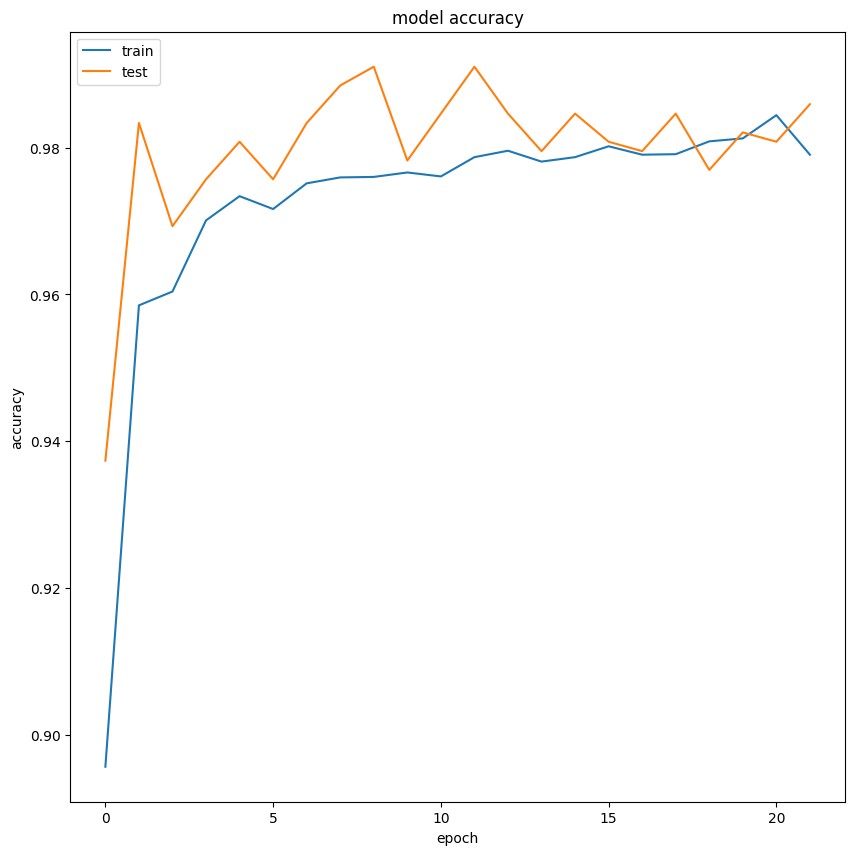

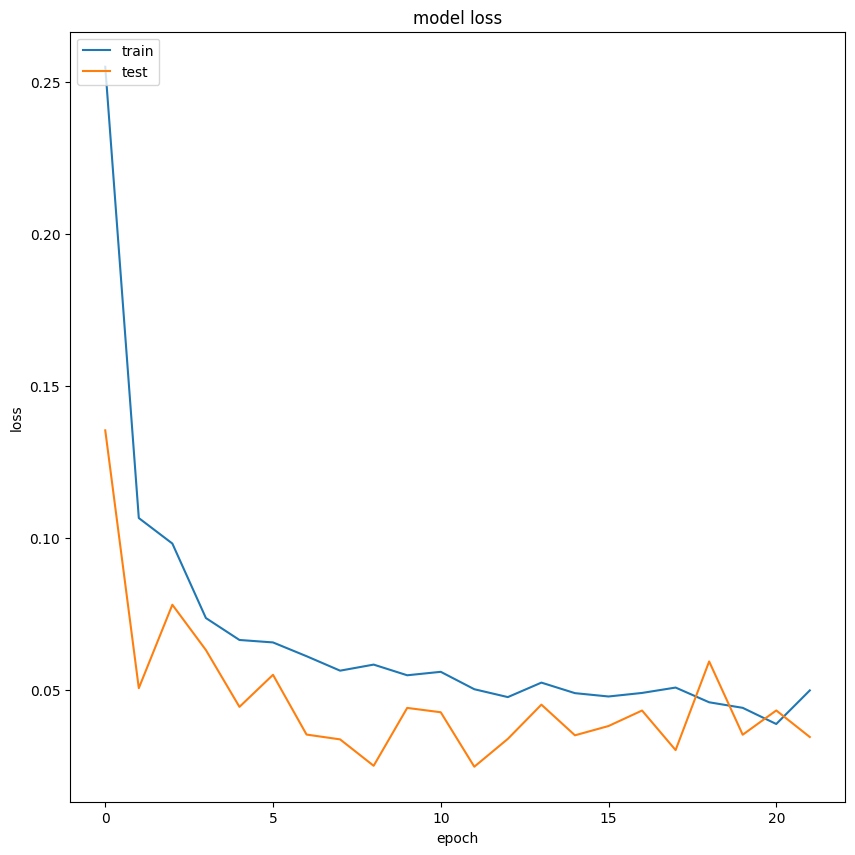

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9838 - loss: 0.0399
Accurracy: 0.9823427796363831
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12403   128]
 [  148  2952]]
precision =  0.9584415584415584 
 recall =  0.952258064516129


In [12]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_loss.png")

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

# Convert predictions to binary (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred_binary)
print(cm)

# compute precision and recall
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
print( 'precision = ', precision, '\n', 'recall = ', recall)

## Model Evaluation on Validation set

3/3 - 0s - 162ms/step - accuracy: 0.9785 - loss: 0.0410
Accurracy: 0.9784946441650391
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[66  2]
 [ 0 25]]
Precision:  0.9259259259259259 
 Recall:  1.0 
 F1-score: 0.9615384615384615


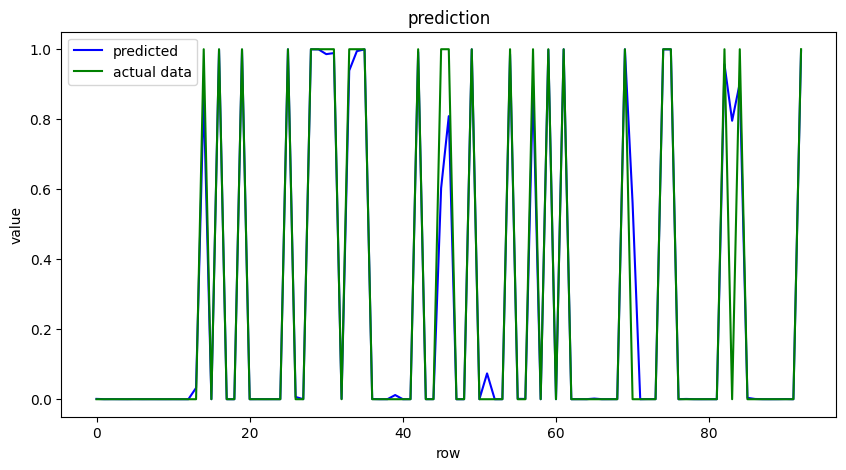

In [14]:
# We pick the last sequence for each id in the test data

seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)

# Similarly, we pick the labels

#print("y_mask")
# serve per prendere solo le label delle sequenze che sono almeno lunghe 50
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
#print("y_mask")
#print(y_mask)
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path)

# test metrics
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

# make predictions and compute confusion matrix
y_pred_test = estimator.predict(seq_array_test_last)
y_true_test = label_array_test_last

# Convert predictions to binary (0 or 1)
y_pred_test_binary = (y_pred_test > 0.5).astype(int)

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test_binary)
print(cm)

# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test_binary)
recall_test = recall_score(y_true_test, y_pred_test_binary)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_verify.png")

# Regression
How many more cycles an in-service engine will last before it fails?

In [16]:
import keras
import keras.backend as K
from keras.layers import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

# define path to save model
model_path = 'regression_model.h5'

## Data Ingestion

In [17]:
# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

## Data Preprocessing

In [18]:
##################################
# Data Preprocessing
##################################

#######
# TRAIN
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# generate label columns for training data
# we will only make use of "label1" for binary classification,
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

#train_df.to_csv('PredictiveManteinanceEngineTraining.csv', encoding='utf-8',index = None)

######
# TEST
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

#test_df.to_csv('PredictiveManteinanceEngineValidation.csv', encoding='utf-8',index = None)

# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

# pick the feature columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# TODO for debug
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols))
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL'])
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

   id  cycle  setting1  setting2  setting3   s1        s2        s3        s4  \
0   1      1  0.632184  0.750000       0.0  0.0  0.545181  0.310661  0.269413   
1   1      2  0.344828  0.250000       0.0  0.0  0.150602  0.379551  0.222316   
2   1      3  0.517241  0.583333       0.0  0.0  0.376506  0.346632  0.322248   
3   1      4  0.741379  0.500000       0.0  0.0  0.370482  0.285154  0.408001   
4   1      5  0.580460  0.500000       0.0  0.0  0.391566  0.352082  0.332039   

    s5  ...       s13       s14       s15  s16       s17  s18  s19       s20  \
0  0.0  ...  0.220588  0.132160  0.308965  0.0  0.333333  0.0  0.0  0.558140   
1  0.0  ...  0.264706  0.204768  0.213159  0.0  0.416667  0.0  0.0  0.682171   
2  0.0  ...  0.220588  0.155640  0.458638  0.0  0.416667  0.0  0.0  0.728682   
3  0.0  ...  0.250000  0.170090  0.257022  0.0  0.250000  0.0  0.0  0.666667   
4  0.0  ...  0.220588  0.152751  0.300885  0.0  0.166667  0.0  0.0  0.658915   

        s21  cycle_norm  
0  0.6

(15631, 1)

## LSTM

In [24]:
import tensorflow as tf
import keras.backend as K

def r2_keras(y_true, y_pred):
    """Coefficient of Determination
    """
    SS_res =  tf.reduce_sum(tf.square( y_true - y_pred ))
    SS_tot = tf.reduce_sum(tf.square( y_true - tf.reduce_mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Next, we build a deep network.
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units.
# Dropout is also applied after each LSTM layer to control overfitting.
# Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

print(model.summary())

# fit the network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 50, 100)        │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,651 (315.04 KB)

 Trainable params: 80,651 (315.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100


75/75 - 5s - 68ms/step - loss: 8748.3877 - mae: 74.8028 - r2_keras: -1.6890e+00 - val_loss: 8158.2417 - val_mae: 71.8735 - val_r2_keras: -2.4274e+00
Epoch 2/100


75/75 - 1s - 10ms/step - loss: 8064.1455 - mae: 70.8171 - r2_keras: -1.4997e+00 - val_loss: 7633.6802 - val_mae: 68.8273 - val_r2_keras: -2.1799e+00
Epoch 3/100


75/75 - 1s - 10ms/step - loss: 7559.0879 - mae: 67.9181 - r2_keras: -1.3319e+00 - val_loss: 7143.7856 - val_mae: 65.9990 - val_r2_keras: -1.9507e+00
Epoch 4/100


75/75 - 1s - 10ms/step - loss: 7074.4878 - mae: 65.1511 - r2_keras: -1.1852e+00 - val_loss: 6679.5122 - val_mae: 63.3381 - val_r2_keras: -1.7354e+00
Epoch 5/100


75/75 - 1s - 9ms/step - loss: 6622.8511 - mae: 62.6172 - r2_keras: -1.0446e+00 - val_loss: 6247.2373 - val_mae: 60.8789 - val_r2_keras: -1.5370e+00
Epoch 6/100


75/75 - 1s - 10ms/step - loss: 6201.1719 - mae: 60.2248 - r2_keras: -9.1446e-01 - val_loss: 5840.1650 - val_mae: 58.5828 - val_r2_keras: -1.3525e+00
Epoch 7/100


75/75 - 1s - 10ms/step - loss: 5812.6333 - mae: 58.0774 - r2_keras: -7.9362e-01 - val_loss: 5466.3101 - val_mae: 56.4946 - val_r2_keras: -1.1855e+00
Epoch 8/100


75/75 - 1s - 10ms/step - loss: 5447.4336 - mae: 56.0453 - r2_keras: -6.7326e-01 - val_loss: 5118.2578 - val_mae: 54.5749 - val_r2_keras: -1.0325e+00
Epoch 9/100


75/75 - 1s - 10ms/step - loss: 5103.9692 - mae: 54.2144 - r2_keras: -5.7031e-01 - val_loss: 4801.8687 - val_mae: 52.8549 - val_r2_keras: -8.9620e-01
Epoch 10/100


75/75 - 1s - 10ms/step - loss: 4805.9395 - mae: 52.6462 - r2_keras: -4.7830e-01 - val_loss: 4510.7915 - val_mae: 51.2988 - val_r2_keras: -7.7384e-01
Epoch 11/100


75/75 - 1s - 10ms/step - loss: 4538.4077 - mae: 51.2477 - r2_keras: -3.9165e-01 - val_loss: 4251.6562 - val_mae: 49.9420 - val_r2_keras: -6.6818e-01
Epoch 12/100


75/75 - 1s - 9ms/step - loss: 4275.2983 - mae: 49.8241 - r2_keras: -3.1443e-01 - val_loss: 4017.2798 - val_mae: 48.7486 - val_r2_keras: -5.7629e-01
Epoch 13/100


75/75 - 1s - 10ms/step - loss: 4063.1228 - mae: 48.7969 - r2_keras: -2.4929e-01 - val_loss: 3815.1448 - val_mae: 47.7563 - val_r2_keras: -5.0107e-01
Epoch 14/100


75/75 - 1s - 10ms/step - loss: 3877.3813 - mae: 47.9162 - r2_keras: -1.8991e-01 - val_loss: 3642.4434 - val_mae: 46.9471 - val_r2_keras: -4.4126e-01
Epoch 15/100


75/75 - 1s - 12ms/step - loss: 3701.2114 - mae: 47.2002 - r2_keras: -1.3597e-01 - val_loss: 3496.5908 - val_mae: 46.3092 - val_r2_keras: -3.9585e-01
Epoch 16/100


75/75 - 1s - 13ms/step - loss: 3575.9087 - mae: 46.6766 - r2_keras: -9.8860e-02 - val_loss: 3378.4290 - val_mae: 45.8471 - val_r2_keras: -3.6501e-01
Epoch 17/100


75/75 - 1s - 11ms/step - loss: 3466.9861 - mae: 46.3262 - r2_keras: -6.3476e-02 - val_loss: 3289.6946 - val_mae: 45.5589 - val_r2_keras: -3.4867e-01
Epoch 18/100


75/75 - 1s - 10ms/step - loss: 3396.8328 - mae: 46.1195 - r2_keras: -4.3226e-02 - val_loss: 3225.8276 - val_mae: 45.4286 - val_r2_keras: -3.4525e-01
Epoch 19/100


75/75 - 1s - 10ms/step - loss: 3342.2158 - mae: 46.0619 - r2_keras: -2.7651e-02 - val_loss: 3190.9827 - val_mae: 45.4319 - val_r2_keras: -3.5185e-01
Epoch 20/100


75/75 - 1s - 9ms/step - loss: 3321.8091 - mae: 46.1357 - r2_keras: -1.9756e-02 - val_loss: 3173.8442 - val_mae: 45.5137 - val_r2_keras: -3.6396e-01
Epoch 21/100


75/75 - 1s - 10ms/step - loss: 3309.6304 - mae: 46.2260 - r2_keras: -1.8734e-02 - val_loss: 3169.6694 - val_mae: 45.5758 - val_r2_keras: -3.7165e-01
Epoch 22/100


75/75 - 1s - 10ms/step - loss: 3303.9382 - mae: 46.2614 - r2_keras: -1.7247e-02 - val_loss: 3168.2935 - val_mae: 45.6225 - val_r2_keras: -3.7711e-01
Epoch 23/100


75/75 - 1s - 10ms/step - loss: 3308.5273 - mae: 46.3759 - r2_keras: -1.4975e-02 - val_loss: 3167.9419 - val_mae: 45.6500 - val_r2_keras: -3.8027e-01
Epoch 24/100


75/75 - 1s - 17ms/step - loss: 3312.6296 - mae: 46.3731 - r2_keras: -1.9285e-02 - val_loss: 3167.8618 - val_mae: 45.6676 - val_r2_keras: -3.8237e-01
Epoch 25/100


75/75 - 1s - 9ms/step - loss: 3303.1565 - mae: 46.3847 - r2_keras: -1.5233e-02 - val_loss: 3167.8616 - val_mae: 45.6758 - val_r2_keras: -3.8326e-01
Epoch 26/100


75/75 - 1s - 10ms/step - loss: 3294.5115 - mae: 46.2671 - r2_keras: -1.2957e-02 - val_loss: 3167.8608 - val_mae: 45.6755 - val_r2_keras: -3.8323e-01
Epoch 27/100
75/75 - 1s - 9ms/step - loss: 3307.8213 - mae: 46.4219 - r2_keras: -1.6000e-02 - val_loss: 3167.8608 - val_mae: 45.6757 - val_r2_keras: -3.8325e-01
Epoch 28/100
75/75 - 1s - 9ms/step - loss: 3307.5366 - mae: 46.4379 - r2_keras: -1.8283e-02 - val_loss: 3167.8650 - val_mae: 45.6656 - val_r2_keras: -3.8212e-01
Epoch 29/100


75/75 - 1s - 10ms/step - loss: 3304.2661 - mae: 46.3177 - r2_keras: -1.4724e-02 - val_loss: 3167.8604 - val_mae: 45.6747 - val_r2_keras: -3.8315e-01
Epoch 30/100


75/75 - 1s - 11ms/step - loss: 3303.2878 - mae: 46.3974 - r2_keras: -1.5051e-02 - val_loss: 3167.8596 - val_mae: 45.6697 - val_r2_keras: -3.8262e-01
Epoch 31/100
75/75 - 1s - 19ms/step - loss: 3301.3674 - mae: 46.4156 - r2_keras: -1.5639e-02 - val_loss: 3167.8606 - val_mae: 45.6753 - val_r2_keras: -3.8320e-01
Epoch 32/100
75/75 - 1s - 10ms/step - loss: 3311.7502 - mae: 46.4861 - r2_keras: -1.7763e-02 - val_loss: 3167.8599 - val_mae: 45.6693 - val_r2_keras: -3.8257e-01
Epoch 33/100
75/75 - 1s - 9ms/step - loss: 3304.7148 - mae: 46.3944 - r2_keras: -1.6046e-02 - val_loss: 3167.8650 - val_mae: 45.6785 - val_r2_keras: -3.8354e-01
Epoch 34/100
75/75 - 1s - 9ms/step - loss: 3295.2131 - mae: 46.2443 - r2_keras: -1.3863e-02 - val_loss: 3167.9089 - val_mae: 45.6911 - val_r2_keras: -3.8487e-01
Epoch 35/100
75/75 - 1s - 9ms/step - loss: 3295.8530 - mae: 46.3526 - r2_keras: -1.3013e-02 - val_loss: 3167.8733 - val_mae: 45.6820 - val_r2_keras: -3.8391e-01
Epoch 36/100
75/75 - 1s - 9ms/step - loss: 3

## Model Evaluation on Test set

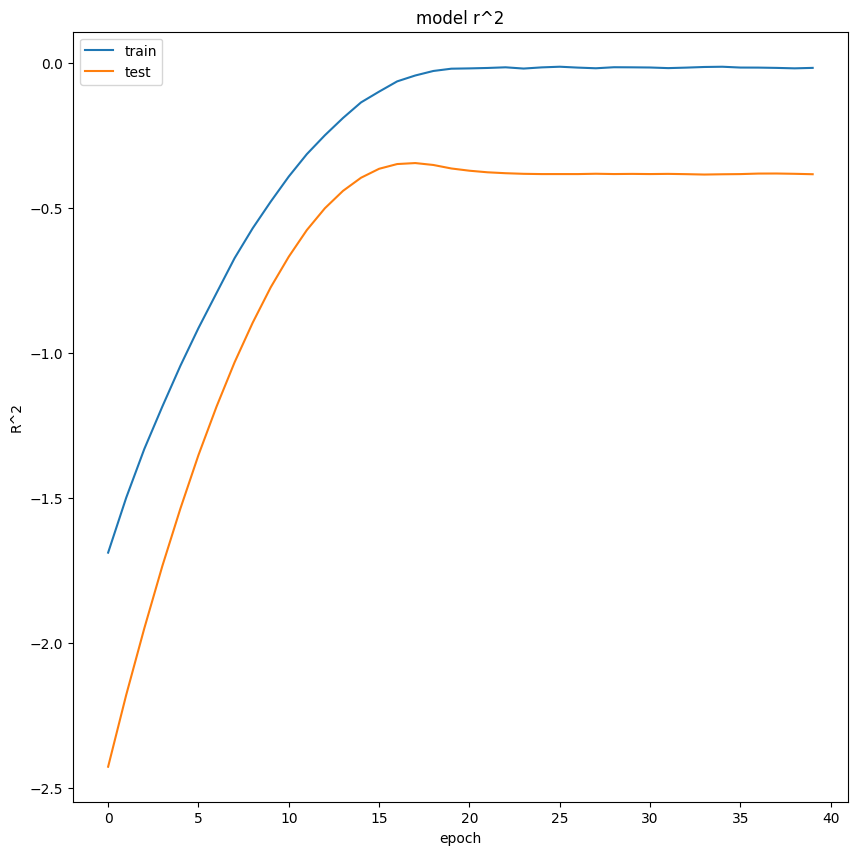

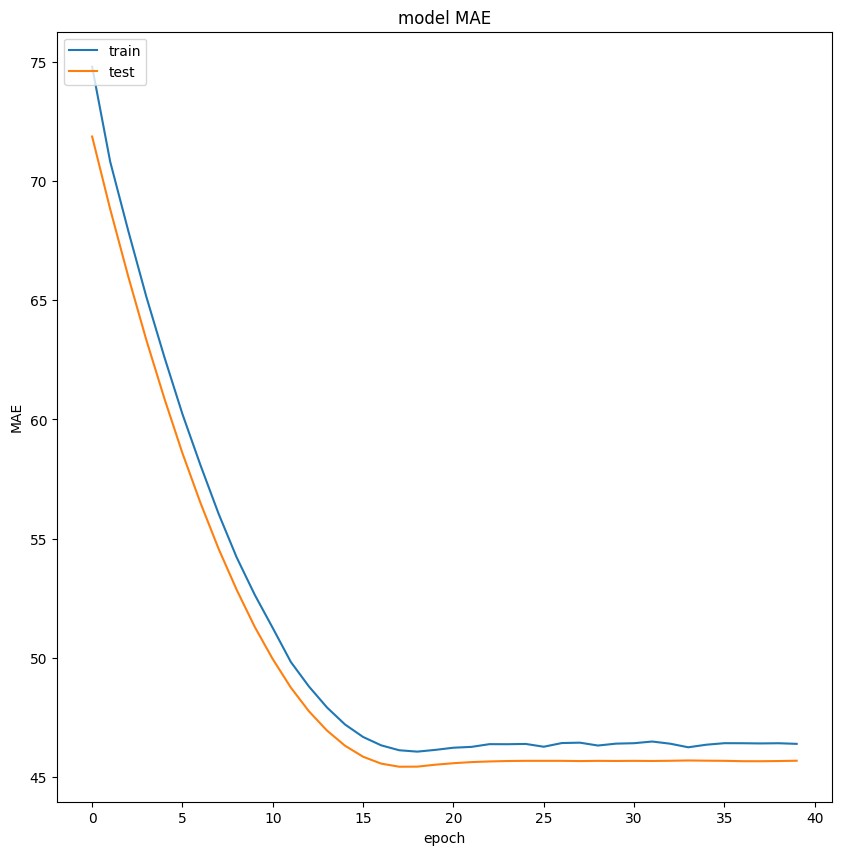

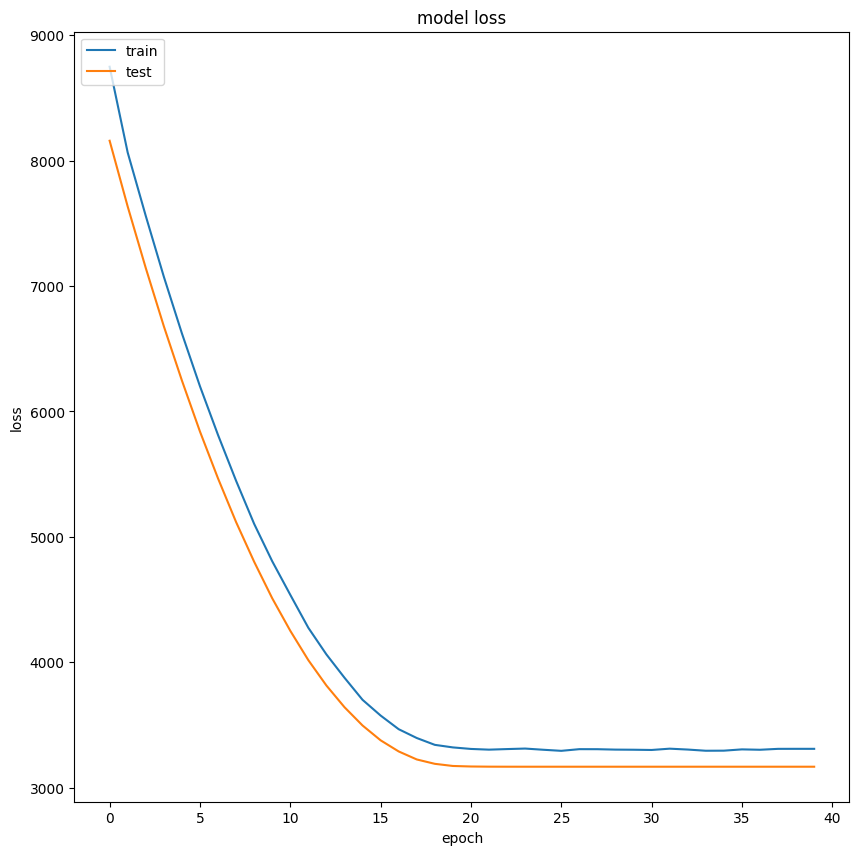

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2915.5332 - mae: 44.2721 - r2_keras: -0.2316

MAE: 46.142303466796875

R^2: -1.01984441280365
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [26]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('submit_train.csv', index = None)

## Evaluate on Validation set

3/3 - 1s - 301ms/step - loss: 1821.3719 - mean_absolute_error: 35.9891 - r2_keras: -9.7251e-02

MAE: 35.989078521728516

R^2: -0.09725066274404526
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step


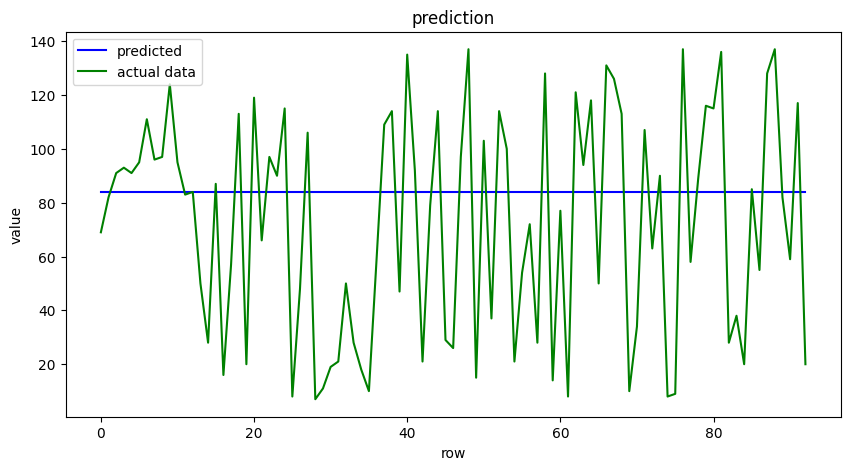

In [27]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")